A user has requested how many seven day prescriptions there are for Aspirin as a proprotion of all prescriptions for Aspirin. The aim is to use as a surrogate for dosette boxes. The Pharmaceutical Journal has a good article [here](https://www.pharmaceutical-journal.com/news-and-analysis/features/are-we-dispensing-too-many-multicompartment-compliance-aids/20206131.article) from earlier in the year that questions are we dispensing too many dosette boxes. It relies on small audits in one or two CCGs to extrapolate to the whole country. Dosette boxes are generally not recommended and as all good pharmacy staff will tell you they are a pain in the backside to dispense and assure yourself of the contents.

We will use Aspirin 75mg as a surrogate for indicating dosette boxes as it is once daily so prescriptions with a seven day course length are indicative of weekly scripts which are sometimes used (erroneously)  to support dispensing in dosette boxes. 

In [1]:
##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = '''
SELECT
  PCO_Name,
  PCO_Code,
  bnf_code AS bnf_code,
  bnf_description AS bnf_name,
  Items,
  Quantity
FROM
  ebmdatalab.tmp_eu.raw_prescribing_data_2019_04 AS presc
  INNER JOIN
  hscic.ccgs AS ccg
ON
  SUBSTR(presc.pco_code,0,3)=ccg.code
WHERE
  (bnf_code LIKE "0209000A0AA%BAB" ##dispersible 75mg
  OR bnf_code LIKE "0209000A0AA%JAJ" ##normal 75mg tabs
  OR bnf_code LIKE "0209000A0AA%KAK") ##enteric coated 75mg
  AND ccg.org_type = 'CCG'
'''

df_aspirin = bq.cached_read(sql, csv_path='aspirin_sevendays.csv')
df_aspirin.rename(columns={'PCO_Code':'pct'}, inplace=True) ##change namre for mapping
df_aspirin['pct'] = df_aspirin['pct'].astype(str).str[:-2] ##here we strip trailing zeros in preparation for mapping
df_aspirin.head(5)

,PCO_Name,pct,bnf_code,bnf_name,Items,Quantity
0,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,2,56
1,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,24,7
2,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,23,28
3,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,1,56
4,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,1,28


In [3]:
##check Englaish total 
eng_total = df_aspirin.sum()[['Items','Quantity']]
eng_total

Items       1830149
Quantity    3134046
dtype: object

In [4]:
##group and sum items
ccg_total = df_aspirin.groupby(['PCO_Name', 'pct']).sum()[['Items']]
ccg_total.head(5)

,,Items
PCO_Name,pct,
"AIREDALE, WHARFEDALE AND CRAVEN CCG",02N,5081
ASHFORD CCG,09C,3521
BARKING & DAGENHAM CCG,07L,6031
BARNET CCG,07M,9132
BARNSLEY CCG,02P,14304


In [5]:
##islolate prescriptions with quantities of 7
df_aspirin_sevendays = df_aspirin.loc[df_aspirin['Quantity'] == 7]
df_aspirin_sevendays.rename(columns={'Items':'sevendayitems'}, inplace=True) ##renaming column
df_aspirin_sevendays.head(5)

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,PCO_Name,pct,bnf_code,bnf_name,sevendayitems,Quantity
1,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,24,7
8,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,1,7
18,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,5,7
21,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,11,7
26,LIVERPOOL CCG,99A,0209000A0AAAJAJ,Aspirin_Tab 75mg,4,7


In [6]:
ccg_sevenday_total = df_aspirin_sevendays.groupby(['PCO_Name', 'pct']).sum()[['sevendayitems']]
ccg_sevenday_total.head(5)

,,sevendayitems
PCO_Name,pct,
"AIREDALE, WHARFEDALE AND CRAVEN CCG",02N,600
ASHFORD CCG,09C,119
BARKING & DAGENHAM CCG,07L,2999
BARNET CCG,07M,3235
BARNSLEY CCG,02P,4509


In [7]:
dosette_boxes_ccg = pd.concat([ccg_total, ccg_sevenday_total], axis=1, join='inner')
dosette_boxes_ccg["percent_seven_days"] = 100*(dosette_boxes_ccg.sevendayitems/dosette_boxes_ccg.Items).fillna(0)
dosette_boxes_ccg.head()


,,Items,sevendayitems,percent_seven_days
PCO_Name,pct,,,
"AIREDALE, WHARFEDALE AND CRAVEN CCG",02N,5081,600,11.808699
ASHFORD CCG,09C,3521,119,3.379722
BARKING & DAGENHAM CCG,07L,6031,2999,49.726414
BARNET CCG,07M,9132,3235,35.424880
BARNSLEY CCG,02P,14304,4509,31.522651


In [8]:
dosette_boxes_ccg.describe()

,Items,sevendayitems,percent_seven_days
count,191.000000,191.000000,191.000000
mean,9581.931937,1977.356021,20.250603
std,6181.690173,2129.294625,16.919803
min,2293.000000,22.000000,0.862069
25%,5200.000000,486.000000,7.401565
50%,8082.000000,1175.000000,13.042832
75%,11464.500000,2893.500000,31.205357
max,41798.000000,11275.000000,72.853246


There are circa 20% of prescriptons for aspirin dispensed as 7 day presriptions indicating hih use of dosette boxes in people on Aspirin. This risies to circa 70% in London in the boroughs of Lambeth and Tower Hamelets.

In [9]:
dosette_boxes_ccg.sort_values('percent_seven_days', ascending=False).head(10)

,,Items,sevendayitems,percent_seven_days
PCO_Name,pct,,,
TOWER HAMLETS CCG,08V,9165,6677,72.853246
LAMBETH CCG,08K,8002,5545,69.295176
WANDSWORTH CCG,08X,8765,5876,67.039361
SOUTHWARK CCG,08Q,6906,4581,66.333623
HAMMERSMITH AND FULHAM CCG,08C,4788,3138,65.538847
EALING CCG,07W,13363,7754,58.025892
HARINGEY CCG,08D,7275,4126,56.714777
SUNDERLAND CCG,00P,19161,10532,54.965816
NEWCASTLE GATESHEAD CCG,13T,20873,10578,50.677909


In [10]:
dosette_boxes_ccg.to_csv('aspirin.csv')

In [11]:
dosette_boxes_ccg.reset_index()


,PCO_Name,pct,Items,sevendayitems,percent_seven_days
0,"AIREDALE, WHARFEDALE AND CRAVEN CCG",02N,5081,600,11.808699
1,ASHFORD CCG,09C,3521,119,3.379722
2,BARKING & DAGENHAM CCG,07L,6031,2999,49.726414
3,BARNET CCG,07M,9132,3235,35.424880
4,BARNSLEY CCG,02P,14304,4509,31.522651
5,BASILDON AND BRENTWOOD CCG,99E,6724,877,13.042832
6,BASSETLAW CCG,02Q,4563,209,4.580320
7,BATH AND NORTH EAST SOMERSET CCG,11E,5836,2480,42.494859
8,BEDFORDSHIRE CCG,06F,13026,1053,8.083832
9,BERKSHIRE WEST CCG,15A,11730,1203,10.255754


In [12]:
dosette_boxes_ccg.plot.bar(x='pct', y='percent_seven_days')


KeyError: 'pct'

In [ ]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(dosette_boxes_ccg, title="percent of aspirin items as 7 days", column='percent_seven_days', separate_london=True)
plt.show()

 ## Now we take a different approach looking at the proportion of tablets that are written as part of a seven day prescription

In [13]:
sql = '''
SELECT
  PCO_Name,
  PCO_Code,
  SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END) AS _7_day_QI,
  SUM(quantity*items) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END),
      SUM(quantity*items)) AS percent_7_day_QI
FROM
ebmdatalab.tmp_eu.raw_prescribing_data_2019_04 AS presc
INNER JOIN
  hscic.ccgs AS ccg
ON
  SUBSTR(presc.pco_code,0,3)=ccg.code
WHERE
    (bnf_code LIKE '0209000A0%AB' ##dispersible 75mg
    OR bnf_code LIKE '0209000A0%AJ' ##normal 75mg tabs
    OR bnf_code LIKE '0209000A0%AK') ##enteric coated 75mg
    AND ccg.org_type = 'CCG'
GROUP BY
  PCO_Name,
  PCO_Code
ORDER BY
  percent_7_day_QI DESC 
'''

df2_aspirin = bq.cached_read(sql, csv_path='aspirintwo_sevendays.csv')
df2_aspirin.rename(columns={'PCO_Code':'pct'}, inplace=True) ##rename column for mapping
df2_aspirin['pct'] = df2_aspirin['pct'].astype(str).str[:-2] ##here we strip trailing zeros in preparation for mapping
df2_aspirin.head(5)

,PCO_Name,pct,_7_day_QI,all_QI,percent_7_day_QI
0,TOWER HAMLETS CCG,08V,46739,167342,0.279302
1,LAMBETH CCG,08K,38815,169609,0.228850
2,WANDSWORTH CCG,08X,41188,186930,0.220339
3,HAMMERSMITH AND FULHAM CCG,08C,21966,106866,0.205547
4,SOUTHWARK CCG,08Q,32109,159797,0.200936


In [14]:
df2_aspirin.describe()

,_7_day_QI,all_QI,percent_7_day_QI
count,191.000000,1.910000e+02,191.000000
mean,13864.691099,2.924456e+05,0.050690
std,14941.107554,1.916826e+05,0.050302
min,154.000000,7.251000e+04,0.002124
25%,3402.000000,1.755030e+05,0.015340
50%,8225.000000,2.391130e+05,0.029248
75%,20254.500000,3.390955e+05,0.079130
max,78925.000000,1.340798e+06,0.279302


Here the mean is 5% up to a maximum of 27.9% with CCGs appearing towards the top of the list in a similar order.

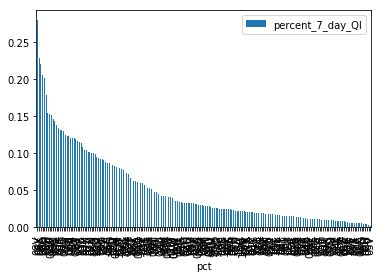

In [15]:
##plot a quick bar chart
df2_aspirin.plot.bar(x='pct', y='percent_7_day_QI')

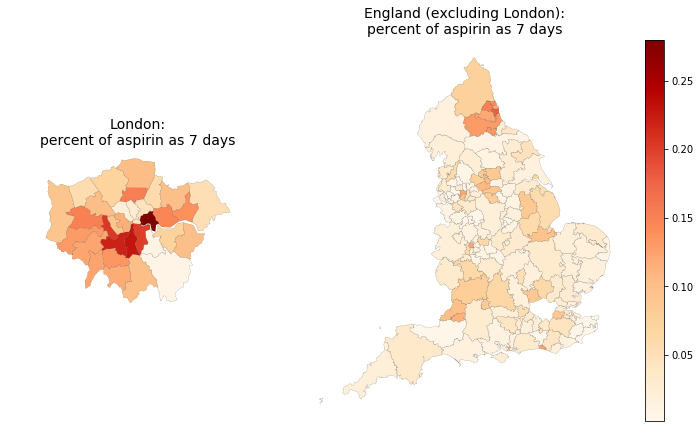

In [16]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df2_aspirin, title="percent of aspirin as 7 days", column='percent_7_day_QI', separate_london=True)
plt.show()

### Other possible drugs - atorvastatin and simvastatin

It is possible that aspirin may not be the best marker, some people do not to put Aspirin dispersible in a dosette box although. Lets try statin as commonly dispensed medicines. We have discounted PPIs as they are sometimes used for short courses.

In [17]:
sql = '''
SELECT
  PCO_Name,
  PCO_Code,
  SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END) AS _7_day_QI,
  SUM(quantity*items) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END),
      SUM(quantity*items)) AS percent_7_day_QI
FROM
  tmp_eu.raw_prescribing_data_2019_04 AS presc
INNER JOIN
  hscic.ccgs AS ccg
ON
  SUBSTR(presc.pco_code,0,3)=ccg.code
WHERE
(bnf_description LIKE 'Simvastatin_Tab%' or bnf_description LIKE 'Atorvastatin_Tab%')
    AND ccg.org_type = 'CCG'
GROUP BY
  PCO_Name,
  PCO_Code
ORDER BY
  percent_7_day_QI DESC
  '''

df2_statin = bq.cached_read(sql, csv_path='statin_sevendays.csv')
df2_statin.rename(columns={'PCO_Code':'pct'}, inplace=True)
df2_statin['pct'] = df2_statin['pct'].astype(str).str[:-2] ##here we strip trailing zeros in preparation for mapping
df2_statin.head(5)

,PCO_Name,pct,_7_day_QI,all_QI,percent_7_day_QI
0,TOWER HAMLETS CCG,08V,137452,725492,0.189460
1,WANDSWORTH CCG,08X,97720,610329,0.160110
2,LAMBETH CCG,08K,102655,668041,0.153666
3,SUNDERLAND CCG,00P,168679,1220536,0.138201
4,SOUTHWARK CCG,08Q,84756,614439,0.137940


In [18]:
df2_statin.describe()

,_7_day_QI,all_QI,percent_7_day_QI
count,191.000000,1.910000e+02,191.000000
mean,33712.879581,9.290169e+05,0.037329
std,37455.328522,5.777718e+05,0.035732
min,294.000000,2.219410e+05,0.001325
25%,8673.000000,5.684835e+05,0.011964
50%,19887.000000,7.696240e+05,0.021759
75%,46032.000000,1.104670e+06,0.056545
max,229131.000000,4.101535e+06,0.189460


Again we see similar CCGs represented although the mean and max is lower

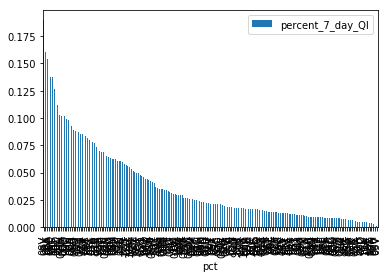

In [19]:
#plot quick bar graph
df2_statin.plot.bar(x='pct', y='percent_7_day_QI')

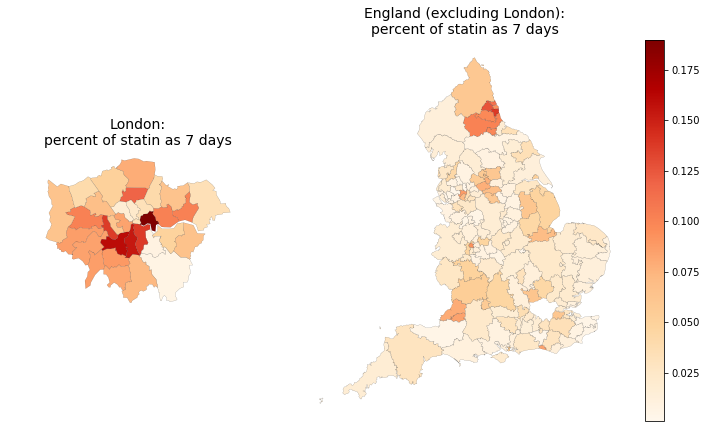

In [20]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df2_statin, title="percent of statin as 7 days", column='percent_7_day_QI', separate_london=True)
plt.show()

### Ramipril

In [21]:
sql = '''
SELECT
  PCO_Name,
  PCO_Code,
  SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END) AS _7_day_QI,
  SUM(quantity*items) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity=7 THEN quantity*items
      ELSE 0
  END),
      SUM(quantity*items)) AS percent_7_day_QI
FROM
  tmp_eu.raw_prescribing_data_2019_04 AS presc
INNER JOIN
  hscic.ccgs AS ccg
ON
  SUBSTR(presc.pco_code,0,3)=ccg.code
WHERE
(bnf_description LIKE 'Rampril_Tab%' or bnf_description LIKE 'Ramipril_Cap%')
    AND ccg.org_type = 'CCG'
GROUP BY
  PCO_Name,
  PCO_Code
ORDER BY
  percent_7_day_QI DESC
    '''

df2_ramipril = bq.cached_read(sql, csv_path='ramipril_sevendays.csv')
df2_ramipril.rename(columns={'PCO_Code':'pct'}, inplace=True)
df2_ramipril['pct'] = df2_ramipril['pct'].astype(str).str[:-2] ##here we strip trailing zeros in preparation for mapping
df2_ramipril.head(5)

,PCO_Name,pct,_7_day_QI,all_QI,percent_7_day_QI
0,TOWER HAMLETS CCG,08V,42077,254273,0.165480
1,SUNDERLAND CCG,00P,26572,200406,0.132591
2,HAMMERSMITH AND FULHAM CCG,08C,14091,113366,0.124297
3,WANDSWORTH CCG,08X,33397,275637,0.121163
4,LAMBETH CCG,08K,39291,328798,0.119499


In [22]:
df2_ramipril.describe()

,_7_day_QI,all_QI,percent_7_day_QI
count,191.000000,1.910000e+02,191.000000
mean,10170.083770,4.015122e+05,0.028431
std,11089.659349,2.861038e+05,0.029228
min,98.000000,1.113220e+05,0.000749
25%,2726.500000,2.340730e+05,0.008415
50%,6475.000000,3.191630e+05,0.015440
75%,13751.500000,4.566530e+05,0.040057
max,82796.000000,1.940133e+06,0.165480


Ramipril has a similar pattern to statins.

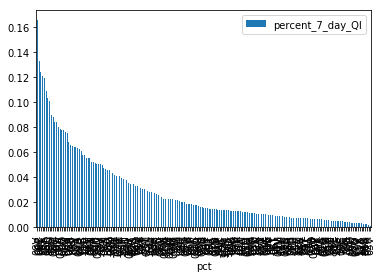

In [23]:
df2_ramipril.plot.bar(x='pct', y='percent_7_day_QI')

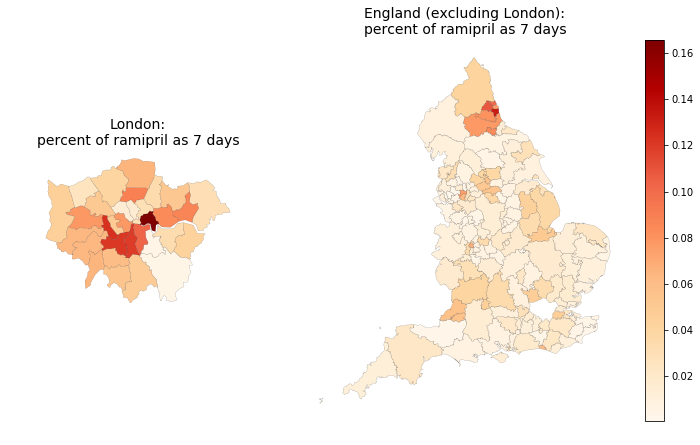

In [24]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df2_ramipril, title="percent of ramipril as 7 days", column='percent_7_day_QI', separate_london=True)
plt.show()